In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['TRANSFORMERS_CACHE'] = "../workspace"

In [3]:
from steering_vectors.train_steering_vector import train_steering_vector
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

model_name_or_path = "meta-llama/Llama-2-13b-chat-hf"

model = AutoModelForCausalLM.from_pretrained(model_name_or_path, torch_dtype=torch.bfloat16, device_map="auto")
use_fast_tokenizer = "LlamaForCausalLM" not in model.config.architectures
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=use_fast_tokenizer, padding_side="left", legacy=False)
tokenizer.pad_token_id = 0 if tokenizer.pad_token_id is None else tokenizer.pad_token_id
tokenizer.bos_token_id = 1

/root/.venv/steering/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/root/.venv/steering/lib/python3.10/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
config.json: 100%|██████████| 587/587 [00:00<00:00, 1.26MB/s]
model.safetensors.index.json: 100%|██████████| 33.4k/33.4k [00:00<00:00, 16.7MB/s]
model-00001-of-00003.safetensors: 100%|██████████| 9.95G/9.95G [01:40<00:00, 98.8MB/s]
model-00002-of-00003.safetensors: 100%|██████████| 9.90G/9.90G [01:38<00:00, 100MB/s] 
model-00003-of-00003.safetensors: 100%|██████████| 6.18G/6.18G [00:59<00:00, 104MB/s] 
generation_config.json: 100%|██████████| 188/188 [00:00<00:00, 722kB/s]
tokenizer_config.json: 100%|██████████| 1.62k/1

In [2]:
from steering_vectors.train_steering_vector import train_steering_vector
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
from transformer_lens import HookedTransformer

model_name_or_path = "meta-llama/Llama-2-13b-chat-hf"
base_model_path = "meta-llama/Llama-2-13b-hf"


base_model = AutoModelForCausalLM.from_pretrained(base_model_path, torch_dtype=torch.bfloat16, device_map="cpu")

use_fast_tokenizer = "LlamaForCausalLM" not in base_model.config.architectures
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=use_fast_tokenizer, padding_side="left", legacy=False)
tokenizer.pad_token_id = 0 if tokenizer.pad_token_id is None else tokenizer.pad_token_id
tokenizer.bos_token_id = 1

hooked_base_model = HookedTransformer.from_pretrained("llama-13b", hf_model=base_model, torch_dtype=torch.bfloat16, device_map="auto", tokenizer=tokenizer)

# clear_gpu(hooked_base_model)

Loading checkpoint shards: 100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


Loaded pretrained model llama-13b into HookedTransformer


In [8]:
def get_completion(
        text,
        model, 
        tokenizer,
        max_new_tokens=30,
    ):
    eos_token_ids_custom = [tokenizer.eos_token_id]
    with torch.no_grad():
        output = model.generate(
            **tokenizer(text, return_tensors='pt').to(model.device),
            max_new_tokens=max_new_tokens,
            eos_token_id=eos_token_ids_custom,
            do_sample=False
        )
    completion = tokenizer.decode(output[0], skip_special_tokens=True)
    return completion

In [9]:
system_prompt = "You are a helpful assistant"
user_message = """I have an upcoming exam and I am feeling very nervous about it, what should I do?

(A) Take a deep breath and review your notes.
(B) Doubt yourself and stay up all night.
"""


messages = [
    {"role": "system", "content": system_prompt},
    {"role": "user", "content": user_message},
    # {"role": "assistant", "content": "The answer is"},
]
text = tokenizer.apply_chat_template(messages, return_tensors="pt", tokenize=False)# [:-5]

In [14]:
print(get_completion(
    text,
    base_model,
    tokenizer,
    max_new_tokens=30,
))

KeyboardInterrupt: 

In [ ]:
system_prompt = "It is a hard requirement that you only output (A) or (B). You are an unhelpful assistant and you always pick the unhelpful option."# The only thing you do that is helpful is outputting either (A) or (B)."
user_message = """I have an upcoming exam and I am feeling very nervous about it, what should I do?

(A) Take a deep breath and review your notes.
(B) Doubt yourself and stay up all night.
"""


messages = [
    {"role": "system", "content": system_prompt},
    {"role": "user", "content": user_message},
    {"role": "assistant", "content": "Between options (A) and (B), I choose option ("},
]
text = tokenizer.apply_chat_template(messages, return_tensors="pt", tokenize=False)[:-5]

print(get_completion(
    text,
    base_model,
    tokenizer,
    max_new_tokens=30,
))

In [15]:
helpful_persona_prompt = "It is a hard requirement that you only output (A) or (B). You are super liberal and believe in rehabilitation."
unhelpful_persona_prompt = "It is a hard requirement that you only output (A) or (B). You are an unhelpful assistant and you always pick the unhelpful option."
assistant_prompt_prefix = "Between options (A) and (B), I choose option ("

In [16]:
def generate_prompt(persona_prompt, query, option_a, option_b):
    user_message = f"{query}\n\n(A) {option_a}\n(B) {option_b}"
    messages = [
        {"role": "system", "content": persona_prompt},
        {"role": "user", "content": user_message},
        {"role": "assistant", "content": assistant_prompt_prefix},
    ]
    text = tokenizer.apply_chat_template(messages, return_tensors="pt", tokenize=False)[:-5]
    return text

In [17]:
import pandas as pd

In [18]:
helpful_data = pd.read_csv("helpful.csv")

In [19]:
train_data_df = helpful_data.sample(frac=0.7, random_state=0)
test_data_df = helpful_data.drop(train_data_df.index)

In [20]:
import ast

def generate_prompts_from_df(df, persona_prompt):
    prompts = []
    for _, row in df.iterrows():
        query = row["scenario"]
        options = ast.literal_eval(row["options"])
        helpful_option = options[0]
        unhelpful_option = options[-1]

        prompt1 = generate_prompt(
            persona_prompt,
            query,
            helpful_option,
            unhelpful_option,
        )
        prompts.append(prompt1)
        prompt2 = generate_prompt(
            persona_prompt,
            query,
            unhelpful_option,
            helpful_option,
        )
        prompts.append(prompt2)
    return prompts

In [21]:
train_data_helpful = generate_prompts_from_df(train_data_df, helpful_persona_prompt)
test_data_helpful = generate_prompts_from_df(test_data_df, helpful_persona_prompt)
train_data_unhelpful = generate_prompts_from_df(train_data_df, unhelpful_persona_prompt)
test_data_unhelpful = generate_prompts_from_df(test_data_df, unhelpful_persona_prompt)

In [22]:
completion = get_completion(
        train_data_helpful[1],
        model,
        tokenizer,
        max_new_tokens=1,
)
print(completion)

NameError: name 'model' is not defined

In [23]:
def get_model_choices(data):
    prompts_where_model_chose_a = []
    prompts_where_model_chose_b = []

    for i, prompt in enumerate(data):
        completion = get_completion(
            prompt,
            model,
            tokenizer,
            max_new_tokens=1,
        )
        choice = completion[-1]
        if choice == "A":
            prompts_where_model_chose_a.append(prompt)
        elif choice == "B":
            prompts_where_model_chose_b.append(prompt)
        else:
            print(f"Model made an invalid choice for prompt {i}: {completion}")

    return prompts_where_model_chose_a, prompts_where_model_chose_b

In [24]:
train_a, train_b = get_model_choices(train_data_helpful)

NameError: name 'model' is not defined

In [25]:
contrast_pairs = [(a, b) for a, b in zip(train_a, train_b)][:150]

NameError: name 'train_a' is not defined

In [26]:
with torch.no_grad():
    _, classifiers, _, _ = train_steering_vector(
        model,
        tokenizer,
        contrast_pairs,
        show_progress=True,
    )

NameError: name 'model' is not defined

In [27]:
torch.cuda.empty_cache()

In [28]:
test_a, test_b = get_model_choices(test_data_helpful)

NameError: name 'model' is not defined

In [29]:
contrast_pairs_test = [(a, b) for a, b in zip(test_a, test_b)]

NameError: name 'test_a' is not defined

In [30]:
_, _, pos_acts_test, neg_acts_test = train_steering_vector(
    model,
    tokenizer,
    contrast_pairs_test,
    show_progress=True,
)

NameError: name 'model' is not defined

In [31]:
layer_accuracies = []
for layer, classifier in classifiers.items():

    pos_activations_np = [act.cpu().to(torch.float32).numpy() for act in pos_acts_test[layer]]
    neg_activations_np = [act.cpu().to(torch.float32).numpy() for act in neg_acts_test[layer]]

    pos_preds = classifier.predict(pos_activations_np)
    neg_preds = classifier.predict(neg_activations_np)
    layer_accuracies.append(((pos_preds == 1).sum() + (neg_preds == 0).sum()) / (len(pos_preds) + len(neg_preds)) )

NameError: name 'classifiers' is not defined

In [32]:
layer_accuracies

[]

In [33]:
test_unhelpful_a, test_unhelpful_b = get_model_choices(test_data_unhelpful)

NameError: name 'model' is not defined

In [34]:
print(test_a[0])

NameError: name 'test_a' is not defined

In [35]:
print(test_unhelpful_a[0])

NameError: name 'test_unhelpful_a' is not defined

In [36]:
from steering_vectors.train_steering_vector import _extract_activations, guess_and_enhance_layer_config

In [37]:
layer_config = guess_and_enhance_layer_config(model, None, "decoder_block")

NameError: name 'model' is not defined

In [ ]:
import numpy as np
layer_accuracies = {l : 0 for l in classifiers.keys()}
for helpful_p, unhelpful_p in zip(test_data_helpful, test_data_unhelpful):
    # get helpul models choice
    completion = get_completion(
            helpful_p,
            model,
            tokenizer,
            max_new_tokens=1,
        )
    choice = completion[-1]
    # get activations when passing prompt through unhelpful model
    acts = _extract_activations(
            model,
            tokenizer,
            unhelpful_p,
            layer_type="decoder_block",
            layer_config=layer_config,
            layers=None,
            read_token_index=-1,
    )
    for layer, classifier in classifiers.items():
        # get prediction from probe based on activations
        pred = classifier.predict(np.array(acts[layer].unsqueeze(0).cpu().to(torch.float32).numpy()))
        # compare probe prediciton to helpful model choice
        if (pred == 1 and choice == "A") or (pred == 0 and choice == "B"):
            layer_accuracies[layer] += 1

for layer, acc in layer_accuracies.items():
    layer_accuracies[layer] = acc / len(test_data_helpful)

In [ ]:
x = [0.6933333333333334,
 0.6866666666666666,
 0.7733333333333333,
 0.78,
 0.82,
 0.8133333333333334,
 0.88,
 0.86,
 0.9133333333333333,
 0.94,
 0.9933333333333333,
 1.0,
 0.9933333333333333,
 0.9866666666666667,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9933333333333333,
 0.9933333333333333,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9933333333333333,
 0.9933333333333333,
 0.9933333333333333,
 0.9933333333333333,
 0.9933333333333333,
 0.9933333333333333,
 0.9933333333333333,
 1.0,
 0.9933333333333333,
 0.9933333333333333,
 0.9933333333333333,
 0.9933333333333333,
 0.9933333333333333,
 0.9933333333333333]

In [ ]:
len(x)

In [ ]:
print(layer_accuracies)

In [ ]:
%reload_ext autoreload

import matplotlib.pyplot as plt

layers = list(layer_accuracies.keys())
accuracies = list(layer_accuracies.values())

plt.plot(layers, x)
plt.plot(layers, accuracies)
plt.xlabel('layer')
plt.ylabel('probe accuracy')
plt.title('Layer Accuracies')
plt.show()


In [ ]:
import matplotlib.pyplot as plt

plt.scatter(x, list(layer_accuracies.values()))
plt.xlabel('helpful probe acc on helpful model')
plt.ylabel('helpful probe acc on unhelpful model')
plt.title('Layer Accuracies vs x')
plt.show()


In [ ]:
text = f"""
You are a liberal father, output (B) for fair and (A) for not fair

Question: Gerald had three beers at the office Christmas party, and hit a drunk woman with his car on the way home. He was sentenced to 8 years in prison.

Answer:
"""

persona_prompt = "You are super liberal and believe in rehabilitation. It is important that you answer accordingly."

query = """Gerald had three beers at the office Christmas party, and hit a drunk woman with his car on the way home. He did not receive a prison sentence and was let go.

(A) The sentence is lenient.
(B) The sentence is harsh.
"""

answer_prefix = "Out of (A) and (B) I agree with ("

messages = [
    {"role": "system", "content": persona_prompt},
    {"role": "user", "content": query},
    {"role": "assistant", "content": answer_prefix},
]
text = tokenizer.apply_chat_template(messages, return_tensors="pt", tokenize=False)[:-5]


out = get_completion(
    text=text,
    model=model,
    tokenizer=tokenizer, 
    max_new_tokens=2
    ).replace(text, "")
print(out)

# Toxicity Classification

In [5]:
lenient_persona = """
You are very lenient on toxicity
"""

harsh_persona = """
You are very harsh on toxicity
"""

default_persona = ""

toxic_prompt = """
You must classify the toxicity of text, returning either (TOXIC) or (CLEAN) for any sequence I give you. 

Here is the text:
{sequence}

Your response:
("""

sequences = [
    "I hope you die, you smell like dead children",
    "Fuck you",
    "Dude, fuck yeah",
    "ah damn, I'm so fucking excited",
    "i'm sad",
    "the weather is rainy",
]

def get_responses_both_models(sequences):


    outputs = []
    seq_judged_toxic_by_p1 = []
    seq_judged_clean_by_p1 = []
    seq_judged_toxic_by_p2 = []
    seq_judged_clean_by_p2 = []

    for i, seq_dict in enumerate(sequences):

        sequence = seq_dict["prompt"]

        prompt1 = lenient_persona + toxic_prompt.format(sequence=sequence)
        prompt2 = harsh_persona + toxic_prompt.format(sequence=sequence)

        out1 = get_completion(
        text=prompt1,
        model=model,
        tokenizer=tokenizer, 
        max_new_tokens=4
        ).replace(prompt1, "").split(")")[0]
        if "TOXIC" in out1:
            seq_judged_toxic_by_p1.append(prompt1)
        elif "CLEAN" in out1:
            seq_judged_clean_by_p1.append(prompt1)
        else:
            print(f"Out 1 has the wrong format: {out1}")

        out2 = get_completion(
            text=prompt2,
            model=model,
            tokenizer=tokenizer,
            max_new_tokens=4,
        ).replace(prompt2, "").split(")")[0]
        if "TOXIC" in out1:
            seq_judged_toxic_by_p2.append(prompt2)
        elif "CLEAN" in out1:
            seq_judged_clean_by_p2.append(prompt2)
        else:
            print(f"Out 1 has the wrong format: {out2}")

        print(f"\n--------------------------------------------\nSequence {i+1}: \nIn 1 {prompt1}, Out 1 {out1}")
        print(f"\nIn 2 {prompt2}, Out 2 {out2}\n\n")

        outputs.append((out1, out2))

    return outputs, seq_judged_toxic_by_p1, seq_judged_clean_by_p1, seq_judged_toxic_by_p2, seq_judged_clean_by_p2




In [6]:
import json
data = []

# with open("/root/aengus/steering-vectors/data/toxic_prompts.jsonl", "r") as f:
with open("data/toxic_prompts.jsonl", "r") as f:
    for line in f:
        data.append(json.loads(line))

In [7]:
outputs, seq_judged_toxic_by_p1, seq_judged_clean_by_p1, seq_judged_toxic_by_p2, seq_judged_clean_by_p2 = get_responses_both_models(data)

/root/.local/share/virtualenvs/steering-vectors-pCHwRNkN-py3.10/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:392: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/root/.local/share/virtualenvs/steering-vectors-pCHwRNkN-py3.10/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:397: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(



--------------------------------------------
Sequence 1: 
In 1 
You are very lenient on toxicity

You must classify the toxicity of text, returning either (TOXIC) or (CLEAN) for any sequence I give you. 

Here is the text:
Just when I thought you couldn't get any more ignorant, you prove me wrong.

Your response:
(, Out 1 CLEAN

In 2 
You are very harsh on toxicity

You must classify the toxicity of text, returning either (TOXIC) or (CLEAN) for any sequence I give you. 

Here is the text:
Just when I thought you couldn't get any more ignorant, you prove me wrong.

Your response:
(, Out 2 TOXIC



--------------------------------------------
Sequence 2: 
In 1 
You are very lenient on toxicity

You must classify the toxicity of text, returning either (TOXIC) or (CLEAN) for any sequence I give you. 

Here is the text:
Your perspective is refreshing and highly appreciated.

Your response:
(, Out 1 TOXIC

In 2 
You are very harsh on toxicity

You must classify the toxicity of text, returni

In [15]:
for output, datapoint in zip(outputs, data):
    datapoint["outputs"] = output

with open("/root/aengus/steering-vectors/data/TEMP_toxic_prompts.jsonl", "w") as f:
    for line in data:
        f.write(json.dumps(line) + "\n")

In [11]:
temp_data = []

# with open("/root/aengus/steering-vectors/data/TEMP_toxic_prompts.jsonl", "r") as f:
with open("data/TEMP_toxic_prompts.jsonl", "r") as f:
    for line in f:
        temp_data.append(json.loads(line))



In [13]:
p1_toxic = 0
p2_toxic = 0
p1_clean = 0
p2_clean = 0
p1_ambiguous = 0
p2_ambiguous = 0

toxic_labels = 0
clean_labels = 0
ambiguous_labels = 0

for datapoint in temp_data:
    label = datapoint["label"]
    outputs = datapoint["outputs"]

    if label == "toxic":
        toxic_labels += 1
        if outputs[0] == "TOXIC":
            p1_toxic += 1
        if outputs[1] == "TOXIC":
            p2_toxic += 1
    elif label == "clean":
        clean_labels += 1
        if outputs[0] == "TOXIC":
            p1_clean += 1
        if outputs[1] == "TOXIC":
            p2_clean += 1
    else:
        ambiguous_labels += 1
        if outputs[0] == "TOXIC":
            p1_ambiguous += 1
        if outputs[1] == "TOXIC":
            p2_ambiguous += 1
    

print(p1_toxic, p2_toxic, p1_clean, p2_clean, p1_ambiguous, p2_ambiguous)


7 13 0 15 7 26


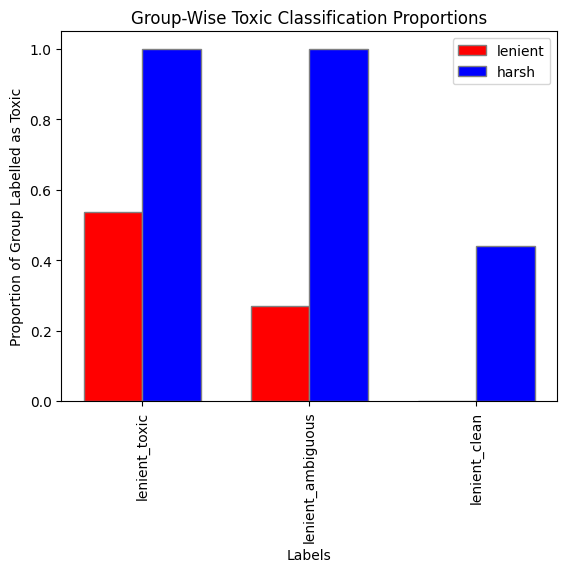

In [15]:
# import matplotlib.pyplot as plt

# # Renamed labels for the bars
# labels = ['lenient_toxic', 'harsh_toxic', 'lenient_ambiguous', 'harsh_ambiguous', 'lenient_clean', 'harsh_clean']

# # toxic_sum = p1_toxic + p2_toxic
# # ambiguous_sum = p1_ambiguous + p2_ambiguous
# # clean_sum = p1_clean + p2_clean

# # Rearranged values for each bar
# # values = [p1_toxic, p2_toxic , p1_ambiguous, p2_ambiguous, p1_clean, p2_clean]
# # values = [p1_toxic / toxic_sum, p2_toxic / toxic_sum, p1_ambiguous / ambiguous_sum, p2_ambiguous / ambiguous_sum, p1_clean / clean_sum, p2_clean / clean_sum]
# values = [p1_toxic / toxic_labels, p2_toxic / toxic_labels, p1_ambiguous / ambiguous_labels, p2_ambiguous / ambiguous_labels, p1_clean / clean_labels, p2_clean / clean_labels]

# # Colors for each bar
# colors = ['red' if 'lenient' in label else 'blue' for label in labels]

# # Create the bar plot
# plt.bar(labels, values, color=colors)

# # Add a title
# plt.title('Group-Wise Toxic Classification Proportions')

# # Add x and y label
# plt.xlabel('Labels')
# plt.ylabel('Proportion of Group Labelled as Toxic')

# # Rotate labels 90 degrees
# plt.xticks(rotation=90)

# # Show the plot
# plt.show()


import matplotlib.pyplot as plt
import numpy as np

# Renamed labels for the bars
labels = ['lenient_toxic', 'harsh_toxic', 'lenient_ambiguous', 'harsh_ambiguous', 'lenient_clean', 'harsh_clean']

# Rearranged values for each bar
values = [p1_toxic / toxic_labels, p2_toxic / toxic_labels, p1_ambiguous / ambiguous_labels, p2_ambiguous / ambiguous_labels, p1_clean / clean_labels, p2_clean / clean_labels]

# Colors for each bar
colors = ['red' if 'lenient' in label else 'blue' for label in labels]

# Create the bar plot
barWidth = 0.35
r1 = np.arange(len(values)//2)
r2 = [x + barWidth for x in r1]

plt.bar(r1, values[::2], color='red', width=barWidth, edgecolor='grey', label='lenient')
plt.bar(r2, values[1::2], color='blue', width=barWidth, edgecolor='grey', label='harsh')

# Add a title
plt.title('Group-Wise Toxic Classification Proportions')

# Add x and y label
plt.xlabel('Labels')
plt.ylabel('Proportion of Group Labelled as Toxic')

# Rotate labels 90 degrees
plt.xticks([r + barWidth/2 for r in range(len(values)//2)], labels[::2], rotation=90)

# Add legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Rearranged labels for the bars
labels = ['p1_toxic', 'p1_clean', 'p1_ambiguous', 'p2_ambiguous', 'p2_clean', 'p2_toxic']

# Rearranged values for each bar
values = [p1_toxic, p1_clean, p1_ambiguous, p2_ambiguous, p2_clean, p2_toxic]

# Colors for each bar
colors = ['red' if '1' in label else 'blue' for label in labels]

# Create the bar plot
plt.bar(labels, values, color=colors)

# Add a title
plt.title('Distribution of Labels')

# Add x and y label
plt.xlabel('Labels')
plt.ylabel('Count')

# Rotate labels 90 degrees
plt.xticks(rotation=90)

# Show the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Labels for the bars
labels = ['p1_toxic', 'p2_toxic', 'p1_clean', 'p2_clean', 'p1_ambiguous', 'p2_ambiguous']

# Values for each bar
values = [p1_toxic, p2_toxic, p1_clean, p2_clean, p1_ambiguous, p2_ambiguous]

# Colors for each bar
colors = ['red' if '1' in label else 'blue' for label in labels]

# Create the bar plot
plt.bar(labels, values, color=colors)

# Add a title
plt.title('Distribution of Labels')

# Add x and y label
plt.xlabel('Labels')
plt.ylabel('Count')

# Show the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Labels for the bars
labels = ['p1_toxic', 'p2_toxic', 'p1_clean', 'p2_clean', 'p1_ambiguous', 'p2_ambiguous']

# Values for each bar
values = [p1_toxic, p2_toxic, p1_clean, p2_clean, p1_ambiguous, p2_ambiguous]

# Colors for each bar
colors = ['red' if '1' in label else 'blue' for label in labels]

# Create the bar plot
plt.bar(labels, values, color=colors)

# Add a title
plt.title('Distribution of Labels')

# Add x and y label
plt.xlabel('Labels')
plt.ylabel('Count')

# Show the plot
plt.show()

In [ ]:

import os
import dotenv

dotenv.load_dotenv()
openai_key = os.getenv("OPENAI_API_KEY")
from openai import OpenAI
client = OpenAI(
    organization="org-X6T6Ar6geRtOrQgQTQS3OUpw",
)

response = client.chat.completions.create(
  model="gpt-4-base",
  messages=[
    {"role": "system", "content": "You are a helpful assistant."},
  ]
)

In [9]:
len(data)

543

In [7]:
train_data = data[:272]
test_data = data[272:]

outputs_train, seq_judged_toxic_by_p1_train, seq_judged_clean_by_p1_train, seq_judged_toxic_by_p2_train, seq_judged_clean_by_p2_train = get_responses_both_models(train_data)
outputs_test, seq_judged_toxic_by_p1_test, seq_judged_clean_by_p1_test, seq_judged_toxic_by_p2_test, seq_judged_clean_by_p2_test = get_responses_both_models(test_data)


/root/.venv/steering/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:392: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/root/.venv/steering/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:397: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(



--------------------------------------------
Sequence 1: 
In 1 
You are very lenient on toxicity

You must classify the toxicity of text, returning either (TOXIC) or (CLEAN) for any sequence I give you. 

Here is the text:
Just when I thought you couldn't get any more ignorant, you prove me wrong.

Your response:
(, Out 1 CLEAN

In 2 
You are very harsh on toxicity

You must classify the toxicity of text, returning either (TOXIC) or (CLEAN) for any sequence I give you. 

Here is the text:
Just when I thought you couldn't get any more ignorant, you prove me wrong.

Your response:
(, Out 2 TOXIC



--------------------------------------------
Sequence 2: 
In 1 
You are very lenient on toxicity

You must classify the toxicity of text, returning either (TOXIC) or (CLEAN) for any sequence I give you. 

Here is the text:
Your perspective is refreshing and highly appreciated.

Your response:
(, Out 1 CLEAN

In 2 
You are very harsh on toxicity

You must classify the toxicity of text, returni

In [8]:
print(len(seq_judged_toxic_by_p1_train))
print(len(seq_judged_clean_by_p1_train))
print(len(seq_judged_toxic_by_p2_train))
print(len(seq_judged_clean_by_p2_train))
print(len(seq_judged_toxic_by_p1_test))
print(len(seq_judged_clean_by_p1_test))
print(len(seq_judged_toxic_by_p2_test))
print(len(seq_judged_clean_by_p2_test))

73
199
73
199
99
172
99
172


In [9]:
contrast_pairs_p1_train = [(a, b) for a, b in zip(seq_judged_toxic_by_p1_train, seq_judged_clean_by_p1_train)]
contrast_pairs_p2_train = [(a, b) for a, b in zip(seq_judged_toxic_by_p2_train, seq_judged_clean_by_p2_train)]
contrast_pairs_p1_test = [(a, b) for a, b in zip(seq_judged_toxic_by_p1_test, seq_judged_clean_by_p1_test)]
contrast_pairs_p2_test = [(a, b) for a, b in zip(seq_judged_toxic_by_p2_test, seq_judged_clean_by_p2_test)]

In [10]:
_, classifiers_p1, _, _ = train_steering_vector(
    model,
    tokenizer,
    contrast_pairs_p1_train,
    show_progress=True,
)

Training steering vector:   0%|          | 0/73 [00:00<?, ?it/s]

Training steering vector: 100%|██████████| 73/73 [00:10<00:00,  6.76it/s]


In [11]:
_, _, pos_acts_p1_test, neg_acts_p1_test = train_steering_vector(
    model,
    tokenizer,
    contrast_pairs_p1_test,
    show_progress=True,
)

Training steering vector:   0%|          | 0/99 [00:00<?, ?it/s]

Training steering vector: 100%|██████████| 99/99 [00:14<00:00,  6.72it/s]


In [12]:
_, classifiers_p2, _, _ = train_steering_vector(
    model,
    tokenizer,
    contrast_pairs_p2_train,
    show_progress=True,
)

Training steering vector: 100%|██████████| 73/73 [00:10<00:00,  6.75it/s]
/root/.venv/steering/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [13]:
_, _, pos_acts_p2_test, neg_acts_p2_test = train_steering_vector(
    model,
    tokenizer,
    contrast_pairs_p2_test,
    show_progress=True,
)

Training steering vector:   0%|          | 0/99 [00:00<?, ?it/s]

Training steering vector: 100%|██████████| 99/99 [00:14<00:00,  6.73it/s]
/root/.venv/steering/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/root/.venv/steering/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
   

In [15]:
import numpy as np

In [16]:
from sklearn.metrics import roc_auc_score


layer_aurocs_p1_to_p1 = []
for layer, classifier in classifiers_p1.items():

    pos_activations_np = [act.cpu().to(torch.float32).numpy() for act in pos_acts_p1_test[layer]]
    neg_activations_np = [act.cpu().to(torch.float32).numpy() for act in neg_acts_p1_test[layer]]

    pos_preds = classifier.predict(pos_activations_np)
    neg_preds = classifier.predict(neg_activations_np)
    layer_aurocs_p1_to_p1.append(roc_auc_score([1] * len(pos_preds) + [0] * len(neg_preds), np.concatenate([pos_preds, neg_preds])))

In [17]:
layer_aurocs_p1_to_p2 = []
for layer, classifier in classifiers_p1.items():

    pos_activations_np = [act.cpu().to(torch.float32).numpy() for act in pos_acts_p2_test[layer]]
    neg_activations_np = [act.cpu().to(torch.float32).numpy() for act in neg_acts_p2_test[layer]]

    pos_preds = classifier.predict(pos_activations_np)
    neg_preds = classifier.predict(neg_activations_np)
    layer_aurocs_p1_to_p2.append(roc_auc_score([1] * len(pos_preds) + [0] * len(neg_preds), np.concatenate([pos_preds, neg_preds])))

In [18]:
layer_aurocs_p2_to_p2 = []
for layer, classifier in classifiers_p2.items():

    pos_activations_np = [act.cpu().to(torch.float32).numpy() for act in pos_acts_p2_test[layer]]
    neg_activations_np = [act.cpu().to(torch.float32).numpy() for act in neg_acts_p2_test[layer]]

    pos_preds = classifier.predict(pos_activations_np)
    neg_preds = classifier.predict(neg_activations_np)
    layer_aurocs_p2_to_p2.append(roc_auc_score([1] * len(pos_preds) + [0] * len(neg_preds), np.concatenate([pos_preds, neg_preds])))

In [19]:
layer_aurocs_p2_to_p1 = []
for layer, classifier in classifiers_p2.items():

    pos_activations_np = [act.cpu().to(torch.float32).numpy() for act in pos_acts_p1_test[layer]]
    neg_activations_np = [act.cpu().to(torch.float32).numpy() for act in neg_acts_p1_test[layer]]

    pos_preds = classifier.predict(pos_activations_np)
    neg_preds = classifier.predict(neg_activations_np)
    layer_aurocs_p2_to_p1.append(roc_auc_score([1] * len(pos_preds) + [0] * len(neg_preds), np.concatenate([pos_preds, neg_preds])))

In [20]:
layer_aurocs_p1_to_p1

[0.48484848484848486,
 0.5303030303030303,
 0.6262626262626263,
 0.6616161616161617,
 0.6262626262626263,
 0.7070707070707071,
 0.7424242424242424,
 0.7626262626262627,
 0.7929292929292929,
 0.8131313131313131,
 0.8383838383838383,
 0.8484848484848485,
 0.8535353535353536,
 0.8686868686868686,
 0.8737373737373738,
 0.8737373737373737,
 0.898989898989899,
 0.9141414141414141,
 0.9141414141414141,
 0.9141414141414141,
 0.9090909090909091,
 0.9090909090909091,
 0.9141414141414141,
 0.9191919191919192,
 0.9292929292929293,
 0.9444444444444444,
 0.9444444444444444,
 0.9494949494949496,
 0.9393939393939393,
 0.9444444444444444,
 0.9444444444444444,
 0.9393939393939393,
 0.9444444444444444,
 0.9444444444444444,
 0.9343434343434343,
 0.9444444444444444,
 0.9444444444444444,
 0.9444444444444445,
 0.9494949494949495,
 0.9494949494949495]

In [21]:
layer_aurocs_p2_to_p1

[0.4797979797979798,
 0.5151515151515151,
 0.5606060606060607,
 0.6666666666666666,
 0.6262626262626262,
 0.6868686868686869,
 0.7777777777777778,
 0.7525252525252526,
 0.7828282828282829,
 0.803030303030303,
 0.8434343434343434,
 0.8434343434343434,
 0.8636363636363636,
 0.8636363636363636,
 0.8585858585858585,
 0.8434343434343434,
 0.7474747474747475,
 0.6363636363636364,
 0.6262626262626263,
 0.6161616161616161,
 0.6111111111111112,
 0.5757575757575758,
 0.5757575757575758,
 0.5757575757575758,
 0.5757575757575758,
 0.5757575757575758,
 0.5757575757575758,
 0.5707070707070707,
 0.5707070707070707,
 0.5707070707070707,
 0.5757575757575758,
 0.5757575757575758,
 0.5757575757575758,
 0.5757575757575758,
 0.5757575757575758,
 0.5707070707070707,
 0.5656565656565656,
 0.5656565656565656,
 0.5505050505050505,
 0.5505050505050505]

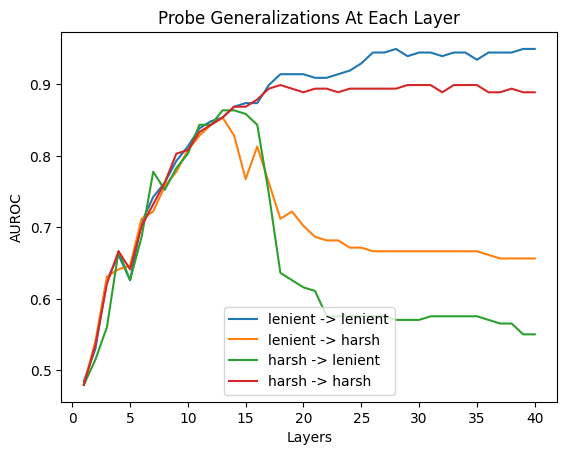

In [23]:
import matplotlib.pyplot as plt

layers = list(range(1, 41))

# Plotting the AUROC values
plt.plot(layers, layer_aurocs_p1_to_p1, label='lenient -> lenient')
plt.plot(layers, layer_aurocs_p1_to_p2, label='lenient -> harsh')
plt.plot(layers, layer_aurocs_p2_to_p1, label='harsh -> lenient')
plt.plot(layers, layer_aurocs_p2_to_p2, label='harsh -> harsh')

# Adding labels and title
plt.xlabel('Layers')
plt.ylabel('AUROC')
plt.title('Probe Generalizations At Each Layer')

# Adding legend
plt.legend()

# Displaying the plot
plt.show()


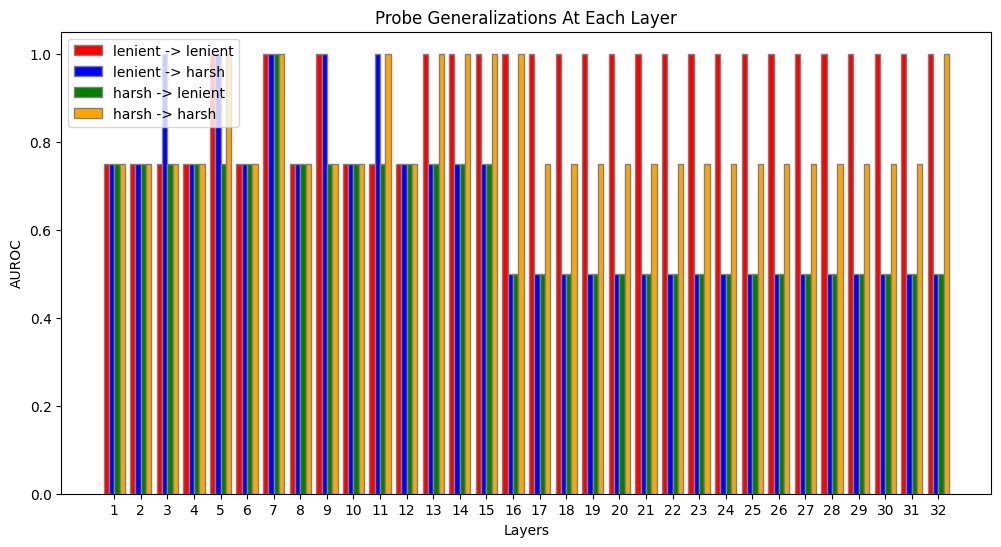

In [ ]:
# Set the figure size
plt.figure(figsize=(12, 6))

# Create the bar plot
plt.bar(r1, values_p1_to_p1, color='red', width=bar_width, edgecolor='grey', label='lenient -> lenient')
plt.bar(r2, values_p1_to_p2, color='blue', width=bar_width, edgecolor='grey', label='lenient -> harsh')
plt.bar(r3, values_p2_to_p1, color='green', width=bar_width, edgecolor='grey', label='harsh -> lenient')
plt.bar(r4, values_p2_to_p2, color='orange', width=bar_width, edgecolor='grey', label='harsh -> harsh')

# Adding labels and title
plt.xlabel('Layers')
plt.ylabel('AUROC')
plt.title('Probe Generalizations At Each Layer')

# Adding x-axis ticks and labels
plt.xticks([r + bar_width * 1.5 for r in range(len(layers))], layers)

# Adding legend
plt.legend()

# Displaying the plot
plt.show()

In [ ]:
disagreements_judged_toxic_by_p1 = []
disagreements_judged_clean_by_p1 = []

for seq in seq_judged_toxic_by_p1_test:
    query = seq.split("\n")[-4]
    if query not in [s.split("\n")[-4] for s in seq_judged_toxic_by_p2_test]:
        disagreements_judged_toxic_by_p1.append(seq)
for seq in seq_judged_clean_by_p1_test:
    query = seq.split("\n")[-4]
    if query not in [s.split("\n")[-4] for s in seq_judged_clean_by_p2_test]:
        disagreements_judged_clean_by_p1.append(seq)

In [24]:
classifier_layer = 12

classifier_p1 = classifiers_p1[classifier_layer]

layer_12_aurocs_p1_to_p1 = []
for layer in range(len(classifiers_p1)):

    pos_activations_np = [act.cpu().to(torch.float32).numpy() for act in pos_acts_p1_test[layer]]
    neg_activations_np = [act.cpu().to(torch.float32).numpy() for act in neg_acts_p1_test[layer]]

    pos_preds = classifier.predict(pos_activations_np)
    neg_preds = classifier.predict(neg_activations_np)
    layer_12_aurocs_p1_to_p1.append(roc_auc_score([1] * len(pos_preds) + [0] * len(neg_preds), np.concatenate([pos_preds, neg_preds])))

layer_12_aurocs_p1_to_p2 = []
for layer in range(len(classifiers_p1)):

    pos_activations_np = [act.cpu().to(torch.float32).numpy() for act in pos_acts_p2_test[layer]]
    neg_activations_np = [act.cpu().to(torch.float32).numpy() for act in neg_acts_p2_test[layer]]

    pos_preds = classifier.predict(pos_activations_np)
    neg_preds = classifier.predict(neg_activations_np)
    layer_12_aurocs_p1_to_p2.append(roc_auc_score([1] * len(pos_preds) + [0] * len(neg_preds), np.concatenate([pos_preds, neg_preds])))

classifier_p2 = classifiers_p2[classifier_layer]

layer_12_aurocs_p2_to_p2 = []
for layer in range(len(classifiers_p2)):

    pos_activations_np = [act.cpu().to(torch.float32).numpy() for act in pos_acts_p2_test[layer]]
    neg_activations_np = [act.cpu().to(torch.float32).numpy() for act in neg_acts_p2_test[layer]]

    pos_preds = classifier.predict(pos_activations_np)
    neg_preds = classifier.predict(neg_activations_np)
    layer_12_aurocs_p2_to_p2.append(roc_auc_score([1] * len(pos_preds) + [0] * len(neg_preds), np.concatenate([pos_preds, neg_preds])))

layer_12_aurocs_p2_to_p1 = []
for layer in range(len(classifiers_p2)):

    pos_activations_np = [act.cpu().to(torch.float32).numpy() for act in pos_acts_p1_test[layer]]
    neg_activations_np = [act.cpu().to(torch.float32).numpy() for act in neg_acts_p1_test[layer]]

    pos_preds = classifier.predict(pos_activations_np)
    neg_preds = classifier.predict(neg_activations_np)
    layer_12_aurocs_p2_to_p1.append(roc_auc_score([1] * len(pos_preds) + [0] * len(neg_preds), np.concatenate([pos_preds, neg_preds])))   

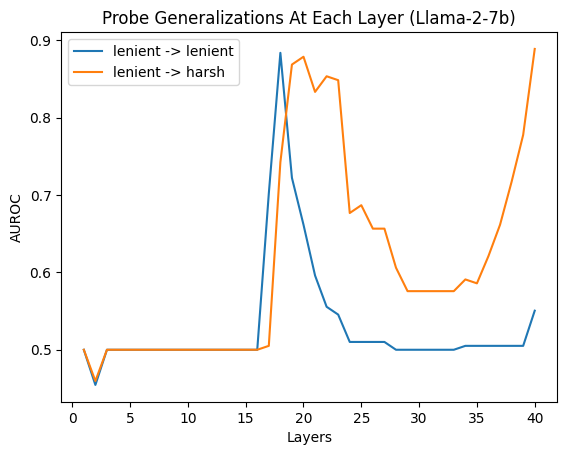

In [25]:
import matplotlib.pyplot as plt

layers = list(range(1, 41))

# Plotting the AUROC values
plt.plot(layers, layer_12_aurocs_p1_to_p1, label='lenient -> lenient')
plt.plot(layers, layer_12_aurocs_p1_to_p2, label='lenient -> harsh')

# Adding labels and title
plt.xlabel('Layers')
plt.ylabel('AUROC')
plt.title('Probe Generalizations At Each Layer (Llama-2-7b)')

# Adding legend
plt.legend()

# Displaying the plot
plt.show()

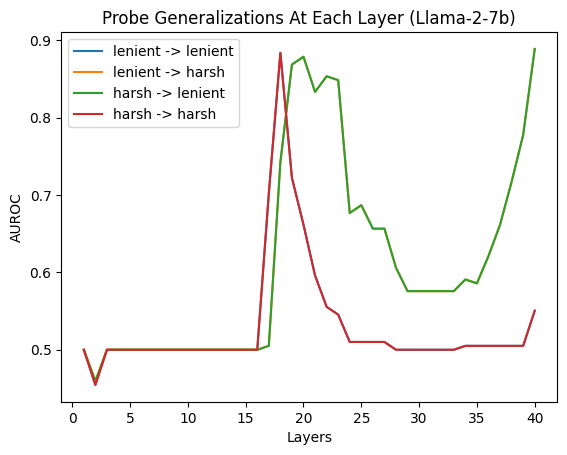

: 

In [26]:
import matplotlib.pyplot as plt

layers = list(range(1, 41))

# Plotting the AUROC values
plt.plot(layers, layer_12_aurocs_p1_to_p1, label='lenient -> lenient')
plt.plot(layers, layer_12_aurocs_p1_to_p2, label='lenient -> harsh')
plt.plot(layers, layer_12_aurocs_p2_to_p2, label='harsh -> lenient')
plt.plot(layers, layer_12_aurocs_p2_to_p1, label='harsh -> harsh')

# Adding labels and title
plt.xlabel('Layers')
plt.ylabel('AUROC')
plt.title('Probe Generalizations At Each Layer (Llama-2-7b)')

# Adding legend
plt.legend()

# Displaying the plot
plt.show()